<a href="https://colab.research.google.com/github/truongvanthanh95/Recommender-System-CDIO/blob/main/Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!curl https://files.grouplens.org/datasets/movielens/ml-latest-small.zip --output data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  2921k      0 --:--:-- --:--:-- --:--:-- 2930k


In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
#@title Read data from csv
import pandas as pd
import numpy as np
ratings = pd.read_csv("ml-latest-small/ratings.csv")
tags = pd.read_csv("ml-latest-small/tags.csv")

In [ ]:
#@title Setup 
movie_tags = pd.crosstab(tags.movieId, tags.tag)
movieId_lookup = {}
movieId_inver_lookup = {}
for idx, movieId in enumerate(list(movie_tags.index)):
  movieId_lookup[movieId] = idx
  movieId_inver_lookup[idx] = movieId 
movie_vectors = movie_tags.to_numpy()
from sklearn.preprocessing import StandardScaler
movie_vectors = StandardScaler().fit_transform(movie_vectors)

In [ ]:
#@title PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 50)
final_movie_vectors = pca.fit_transform(movie_vectors)
count_ratings = ratings.groupby('userId')['movieId'].count()

In [ ]:
#@title Train/test split
userId = list(set(ratings.userId.values))
data = ratings.sample(frac=1, replace=False).reset_index(drop=True)
train_movies = {user: set() for user in userId}
train_input = {user: [] for user in userId}
train_output = {user: [] for user in userId}
test_input = {user: [] for user in userId}
test_output = {user: [] for user in userId}
test_movies = {user: set() for user in userId}
cnt_lk = {user: 0 for user in userId}
for t in data.values.tolist():
  curr_user = t[0]
  curr_movie = int(t[1])
  curr_ratings = t[2]
  if curr_movie not in movieId_lookup:
    continue
  if count_ratings[curr_user] <= 5:
    train_input[curr_user].append(final_movie_vectors[movieId_lookup[curr_movie]])
    train_output[curr_user].append(curr_ratings)
    train_movies[curr_user].add((curr_movie, curr_ratings))
  else:
    if cnt_lk[curr_user] < 0.8 * count_ratings[curr_user]:
      train_input[curr_user].append(final_movie_vectors[movieId_lookup[curr_movie]])
      train_output[curr_user].append(curr_ratings)
      train_movies[curr_user].add((curr_movie, curr_ratings))
      cnt_lk[curr_user] += 1
    else:
      test_input[curr_user].append(final_movie_vectors[movieId_lookup[curr_movie]])
      test_output[curr_user].append(curr_ratings)
      test_movies[curr_user].add((curr_movie, curr_ratings))

In [ ]:
#@title Setup user and movie lookup
num_user = len(userId)
num_movie = len(movieId_lookup)
movies_ncf = {}
movies_ncf_inver = {}
users_ncf = {}
users_ncf_inver = {}
tmp_idx = 0
for user in userId:
  users_ncf[user] = tmp_idx
  users_ncf_inver[tmp_idx] = user
  tmp_idx += 1
tmp_idx = 0
for movie in movieId_lookup:
  movies_ncf[movie] = tmp_idx
  movies_ncf_inver[tmp_idx] = movie
  tmp_idx += 1

In [ ]:
#@title Declare relevant threshold
RELEVANT_THRESHOLD = 3.
MEAN_RATING = ratings.rating.mean()

In [ ]:
#@title Read movie data
movies_data = pd.read_csv("ml-latest-small/movies.csv")
#movies_data = movies_data.set_index('movieId')
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
#@title MovieID lookup
movieId_title = {}
for elm in movies_data.values.tolist():
  movieId_title[elm[0]] = elm[1]

In [ ]:
#@title History form setup
import ipywidgets as widgets
txtbox = widgets.Text(
    value='',
    placeholder='Nhập id của người dùng(chỉ nhập số):',
    description='Id người dùng',
    disabled=False
)
button = widgets.Button(
    description='Xem danh sách',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
result = widgets.Textarea(
    value='',
    placeholder='',
    description='Phim đã xem:',
    disabled=True,
    layout = {'width': '40%', 'height': '200px'}
)
def get_rated_movies(args):
  try:
    curr_user_id = int(txtbox.value)
    #result.close()
    result.value = ''
    if curr_user_id in userId:
      for rated_movie, rating in train_movies[curr_user_id]:
        result.value += movieId_title[rated_movie] + "\n"
  except:
    print("Lỗi")
  #print("Hello")
button.on_click(get_rated_movies)
items = [txtbox, button]
box_container = widgets.HBox(items)
# result.observe(get_rated_movies, names=['value'])
display(box_container)
display(result)

Textarea(value='', description='Phim đã xem:', disabled=True, layout=Layout(height='200px', width='40%'), plac…

In [ ]:
#@title NCF
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
class NCFRecommender:
  def __init__(self, num_cluster = 1, num_neighbor = 10, metric="ball_tree"):
    self.utility_mat = np.zeros(shape=(num_user, num_movie))
    self.num_cluster = num_cluster
    self.num_neighbor = num_neighbor
    self.users_rating_count = {}
    self.metric = metric


  def fit(self, train_movies):
    for user in userId:
      self.users_rating_count[user] = 0
      for entry in train_movies[user]:
        self.utility_mat[users_ncf[user], movies_ncf[entry[0]]] = entry[1]
        self.users_rating_count[user] += 1

    kmeans = KMeans(n_clusters = self.num_cluster, random_state=0).fit(self.utility_mat)
    self.cluster_elements = [[] for _ in range(self.num_cluster)]
    self.cluster_element_vectors = [[] for _ in range(self.num_cluster)]
    self.cluster_lookup = {}
    self.cluster_inver_lookup = {}
    for idx, label in enumerate(kmeans.labels_):
      self.cluster_lookup[users_ncf_inver[idx]] = (label, len(self.cluster_elements[label]))
      self.cluster_inver_lookup[(label, len(self.cluster_elements[label]))] = users_ncf_inver[idx]
      self.cluster_elements[label].append(idx)
      self.cluster_element_vectors[label].append(np.array(self.utility_mat[idx]))

    self.cluster_neighbors = [NearestNeighbors(n_neighbors=self.num_neighbor + 5, algorithm=self.metric) for _ in range(self.num_cluster)]
    self.cluster_indices = []
    for cluster in range(self.num_cluster):
      # print(np.array(self.cluster_element_vectors[cluster]).shape)
      self.cluster_neighbors[cluster].fit(np.array(self.cluster_element_vectors[cluster]))
      
      distances, indices = self.cluster_neighbors[cluster].kneighbors(np.array(self.cluster_element_vectors[cluster]))
      self.cluster_indices.append(indices)
    users_total_rating = self.utility_mat.sum(axis = 1)
    users_total_count = self.utility_mat.astype('bool').sum(axis = 1)
    self.users_mean_rating = users_total_rating / users_total_count
  

  def predict(self, user, movie):
    curr_cluster = self.cluster_lookup[user][0]
    curr_idx = self.cluster_lookup[user][1]
    count_neighbor = 0
    total_rating = 0
    total_weight = 0
    best = []
    for elm in self.cluster_indices[curr_cluster][curr_idx]:
      if count_neighbor == self.num_neighbor:
        break
      nxt_user = self.cluster_inver_lookup[(curr_cluster, elm)]
      pearson = np.corrcoef(self.utility_mat[users_ncf[user]], self.utility_mat[users_ncf[nxt_user]])[0, 1]
      best.append((pearson, nxt_user, movie))
    best.sort(key=lambda x: abs(x[0]))
    best.reverse()
    for i in range(len(best)):
      nxt_user = best[i][1]
      pearson = best[i][0]
      movie = best[i][2]
      if self.utility_mat[users_ncf[nxt_user]][movies_ncf[movie]] != 0:
        total_rating += pearson * (self.utility_mat[users_ncf[nxt_user], movies_ncf[movie]] - self.users_mean_rating[users_ncf[nxt_user]])
        total_weight += abs(pearson)
        count_neighbor += 1
    predict_rating = self.users_mean_rating[users_ncf[user]]
    if total_weight > 0:
      predict_rating = self.users_mean_rating[users_ncf[user]] + total_rating / total_weight
    if predict_rating > 5:
      predict_rating = 5
    if predict_rating <= 0:
      predict_rating = 0.5
    return predict_rating
  
  def rmse(self, test_movies):
    curr_rmse = 0
    count_total = 0
    for user in userId:
      if len(test_movies[user]) > 0:
        count_total += len(test_movies[user])
        for entry in test_movies[user]:
          curr_movie = entry[0]
          curr_rating = entry[1]
          predict_rating = self.predict(user, curr_movie)

          curr_rmse += (predict_rating - curr_rating) ** 2
          # print(predict_rating, curr_rating, curr_rmse)
    return np.sqrt(curr_rmse / count_total)
  
  def ap10(self, user, train_movies, test_movies):
    if len(test_movies[user]) > 0:
      count_relevant = 0
      relevant_set = set()
      for elm in test_movies[user]:
        if elm[1] >= RELEVANT_THRESHOLD:
          relevant_set.add(elm[0])
          count_relevant += 1
      watched = set()
      for elm in train_movies[user]:
        watched.add(elm[0])
      scores = []
      for movie in movieId_lookup:
        scores.append(self.predict(user, movie))
      scores = np.array(scores)
      sorted_movies = (-scores).argsort()
      count_rec = 0
      precision = 0
      rank = 0
      for idx in sorted_movies:
        if count_rec == 10:
          break
        if movies_ncf_inver[idx] in watched:
          continue
        if movies_ncf_inver[idx] in relevant_set:
          rank += 1
        count_rec += 1
        precision += rank / count_rec
      if len(relevant_set) > 0:
        return precision / len(relevant_set)
    return 0

  def hitrate_user(self, user, train_movies, test_movies):
    hit = 0
    if len(test_movies[user]) > 0:
      watched = set()
      for elm in train_movies[user]:
        watched.add(elm[0])
      goal_movies = set()
      for elm in test_movies[user]:
        goal_movies.add(elm[0])
      scores = []
      for movie in movieId_lookup:
        scores.append(self.predict(user, movie))
      scores = np.array(scores)
      sorted_movies = (-scores).argsort()
      count_rec = 0
      rank = 0
      for idx in sorted_movies:
        if count_rec == 10:
          break
        if movies_ncf_inver[idx] in watched:
          continue
        rank += 1
        if movies_ncf_inver[idx] in goal_movies:
          hit += 1 / rank
    return hit
  
  def get_recommendation(self, user, train_movies, test_movies):
      watched = set()
      for elm in train_movies[user]:
        watched.add(elm[0])
      scores = []
      for movie in movieId_lookup:
        scores.append(self.predict(user, movie))
      scores = np.array(scores)
      sorted_movies = (-scores).argsort()
      count_rec = 0
      recommendations = []
      for idx in sorted_movies:
        if count_rec == 10:
          break
        if movies_ncf_inver[idx] in watched:
          continue
        recommendations.append(movies_ncf_inver[idx])
        count_rec += 1
      return recommendations

  def map10(self, train_movies, test_movies):
    map = 0
    for user in userId:
      map += self.ap10(user, train_movies, test_movies)
    return map / len(userId)
  

  def hitrate(self, train_movies, test_movies):
    mhit = 0
    for user in userId:
      mhit += self.hitrate_user(user, train_movies, test_movies)
    return mhit / len(userId)

In [ ]:
#@title CBF
from sklearn.linear_model import Ridge
class RidgeContentRecommender:
  def __init__(self, alpha=1):
    self.model = {user: Ridge(alpha=alpha, max_iter=200) for user in userId}
  

  def fit(self, train_input, train_output):
    for user in userId:
      if train_input[user]:
        self.model[user].fit(train_input[user], train_output[user])


  def rmse(self, test_input, test_output):
    total = 0
    total_cnt = 0
    for user in userId:
      if test_input[user] and train_input[user]:
        test_predict = self.model[user].predict(test_input[user])
        for i in range(len(test_predict)):
          if test_predict[i] <= 0:
            test_predict[i] = 0.5
          elif test_predict[i] > 5:
            test_predict[i] = 5
        test_output[user] = np.array(test_output[user])
        total += ((test_predict - test_output[user]) ** 2).sum()
        total_cnt += len(test_input[user])
    return np.sqrt(total / total_cnt)


  def ap10(self, user, train_movies, test_movies):
    curr_relevant_set = set()
    watched_movies = set()
    for entry in test_movies[user]:
      if entry[1] >= RELEVANT_THRESHOLD:
        curr_relevant_set.add(entry[0])
    for entry in train_movies[user]:
      watched_movies.add(entry[0])
    curr_scores = self.model[user].predict(final_movie_vectors)
    sorted_movies = (-curr_scores).argsort()
    total_rec = 0
    curr_hit = 0
    curr_precision = 0
    ap = 0
    for idx in sorted_movies:
      if total_rec == 10:
        break
      if movieId_inver_lookup[idx] in watched_movies:
        continue
      total_rec += 1
      if movieId_inver_lookup[idx] in curr_relevant_set:
        curr_hit += 1
        curr_precision += curr_hit / total_rec
    if len(curr_relevant_set) > 0:
        ap = 1 / len(curr_relevant_set) * curr_precision
    return ap

  def hitrate_user(self, user, train_movies, test_movies):
    total_cnt = len(test_input[user])
    watched_movies = set()

    for entry in train_movies[user]:
      watched_movies.add(entry[0])
    goal_movies = set()
    for entry in test_movies[user]:
      goal_movies.add(entry[0])
    curr_scores = self.model[user].predict(final_movie_vectors)
    sorted_movies = (-curr_scores).argsort()
    total_rec = 0
    curr_hit = 0
    for idx in sorted_movies:
      if total_rec == 10:
        break
      if movieId_inver_lookup[idx] in watched_movies:
        continue
      total_rec += 1
      if movieId_inver_lookup[idx] in goal_movies:
        curr_hit += 1 / total_rec
    return curr_hit

  def hitrate(self, train_movies, test_movies):
    hit = 0
    for user in userId:
      hit += self.hitrate_user(user, train_movies, test_movies)
    return hit / len(userId)

  def map10(self, train_movies, test_movies):
    map = 0
    for user in userId:
      map += self.ap10(user, train_movies, test_movies)
    return map / len(userId)


  def predict(self, user, movie):
    if movie not in movieId_lookup:
      return 3
    predict_rating = self.model[user].predict([final_movie_vectors[movieId_lookup[movie]]])
    return np.maximum(np.minimum(5, predict_rating), 0.5)[0]
  
  def get_recommendation(self, user, train_movies, test_movies):
      watched = set()
      for elm in train_movies[user]:
        watched.add(elm[0])
      scores = []
      for movie in movieId_lookup:
        scores.append(self.predict(user, movie))
      scores = np.array(scores)
      sorted_movies = (-scores).argsort()
      count_rec = 0
      recommendations = []
      for idx in sorted_movies:
        if count_rec == 10:
          break
        if movies_ncf_inver[idx] in watched:
          continue
        recommendations.append(movies_ncf_inver[idx])
        count_rec += 1
      return recommendations

In [ ]:
#@title generating training data for hybrid method
gen_train_input = []
gen_train_output = []
for user in userId:
  for entry in train_movies[user]:
    cbf_score = cbf.predict(user, entry[0])
    ncf_score = ncf.predict(user, movie)
    gen_train_input.append([cbf_score, ncf_score])
    gen_train_output.append(entry[1])
gen_train_input = np.array(gen_train_input)
gen_train_output = np.array(gen_train_output)

In [ ]:
#@title some model testing
cbf = RidgeContentRecommender(alpha=30)
cbf.fit(train_input, train_output)
ncf = NCFRecommender(num_cluster=3)
ncf.fit(train_movies)

In [ ]:
#@title Recommendation form
search_box = widgets.Text(
    value='',
    placeholder='Nhập id của người dùng(chỉ nhập số):',
    description='Id người dùng',
    disabled=False
)
rec_button = widgets.Button(
    description='Xem gợi ý',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
rec_result = widgets.Textarea(
    value='',
    placeholder='',
    description='Danh sách gợi ý:',
    disabled=True,
    layout = {'width': '40%', 'height': '200px'}
)

select_model = widgets.Select(
    options=['NCF', 'CBF'],
    value='NCF',
    # rows=10,
    description='Mô hình:',
    disabled=False
)
def get_recommendation_list(args):
  try:
    curr_user_id = int(search_box.value)
    #result.close()
    rec_result.value = ''
    if curr_user_id in userId:
      if select_model.value == 'NCF':
        for movie in ncf.get_recommendation(curr_user_id, train_movies, test_movies):
          rec_result.value += f'{movieId_title[movie]}\n'
      elif select_model.value == 'CBF':
        for movie in cbf.get_recommendation(curr_user_id, train_movies, test_movies):
          rec_result.value += f'{movieId_title[movie]}\n'
  except:
    print("Lỗi")
  #print("Hello")
rec_button.on_click(get_recommendation_list)
rec_items = [search_box, select_model, rec_button]
rec_box_container = widgets.HBox(rec_items)
# result.observe(get_rated_movies, names=['value'])
display(rec_box_container)
display(rec_result)

Textarea(value='', description='Danh sách gợi ý:', disabled=True, layout=Layout(height='200px', width='40%'), …

In [ ]:
cbf.get_recommendation(1, train_movies, test_movies)

[48516, 54503, 1237, 99917, 116897, 80906, 115149, 60069, 410, 87430]

In [ ]:
train_params = [0.5, 0.5]

In [ ]:
total_test = 0
rmse = 0
for user in userId:
  for entry in test_movies[user]:
    predict_score = cbf.predict(user, movie) * 0.5 + ncf.predict(user, movie) * 0.5 # + train_params.intercept_
    predict_score = min(5, max(0.5, predict_score))
    rmse += (predict_score - entry[1]) ** 2
    total_test += 1
print(f"Hybrid rmse {np.sqrt(rmse / total_test)}")
print(f"Content Based rmse: {cbf.rmse(test_input, test_output)}")
print(f"Neighborhood Collaborative Filtering rmse: {ncf.rmse(test_movies)}")

Hybrid rmse 0.8872029152368545
Content Based rmse: 1.0353669972783817
Neighborhood Collaborative Filtering rmse: 0.8617173089609893


In [ ]:
def ap10(user, train_movies, test_movies):
    if len(test_movies[user]) > 0:
      count_relevant = 0
      relevant_set = set()
      for elm in test_movies[user]:
        if elm[1] >= RELEVANT_THRESHOLD:
          relevant_set.add(elm[0])
          count_relevant += 1
      watched = set()
      for elm in train_movies[user]:
        watched.add(elm[0])
      scores = []
      for movie in movieId_lookup:
        scores.append(cbf.predict(user, movie) * train_params[0] + ncf.predict(user, movie) * train_params[1])
      scores = np.array(scores)
      sorted_movies = (-scores).argsort()
      count_rec = 0
      precision = 0
      rank = 0
      for idx in sorted_movies:
        if count_rec == 10:
          break
        if movies_ncf_inver[idx] in watched:
          continue
        if movies_ncf_inver[idx] in relevant_set:
          rank += 1
        count_rec += 1
        precision += rank / count_rec
      if len(relevant_set) > 0:
        return precision / len(relevant_set)
    return 0

In [ ]:
def map10(train_movies, test_movies):
    map = 0
    for user in userId:
      map += ap10(user, train_movies, test_movies)
    return map / len(userId)


In [ ]:
def hitrate_user(user, train_movies, test_movies):
    hit = 0
    if len(test_movies[user]) > 0:
      watched = set()
      for elm in train_movies[user]:
        watched.add(elm[0])
      goal_movies = set()
      for elm in test_movies[user]:
        goal_movies.add(elm[0])
      scores = []
      for movie in movieId_lookup:
        scores.append(cbf.predict(user, movie) * train_params[0] + ncf.predict(user, movie) * train_params[1])
      scores = np.array(scores)
      sorted_movies = (-scores).argsort()
      count_rec = 0
      rank = 0
      for idx in sorted_movies:
        if count_rec == 10:
          break
        if movies_ncf_inver[idx] in watched:
          continue
        rank += 1
        if movies_ncf_inver[idx] in goal_movies:
          hit += 1 / rank
    return hit

In [ ]:
def hitrate(train_movies, test_movies):
    mhit = 0
    for user in userId:
      mhit += hitrate_user(user, train_movies, test_movies)
    return mhit / len(userId)

In [ ]:
print(map10(train_movies, test_movies))
print(hitrate(train_movies, test_movies))

0.0023910898603521553
0.00337417750871733


In [ ]:
rmse_hybrid = []
map10_hybrid = []
hitrate_hybrid = []
rmse_ncf = []
rmse_cbf = []
map10_ncf = []
map10_cbf = []
hitrate_ncf = []
hitrate_cbf = []
for cbf_param in np.arange(0.1, 1, 0.1):
    cbf = RidgeContentRecommender(alpha=30)
    cbf.fit(train_input, train_output)
    ncf = NCFRecommender(num_cluster=3)
    ncf.fit(train_movies)
    train_params[0] = cbf_param
    train_params[1] = 1 - cbf_param
    total_test = 0
    rmse = 0
    for user in userId:
      for entry in test_movies[user]:
        predict_score = cbf.predict(user, movie) * train_params[0] + ncf.predict(user, movie) * train_params[1]
        predict_score = min(5, max(0.5, predict_score))
        rmse += (predict_score - entry[1]) ** 2
        total_test += 1
    
    rmse_hybrid.append(np.sqrt(rmse / total_test))
    rmse_ncf.append(ncf.rmse(test_movies))
    rmse_cbf.append(cbf.rmse(test_input, test_output))
    map10_hybrid.append(map10(train_movies, test_movies))
    map10_ncf.append(ncf.map10(train_movies, test_movies))
    map10_cbf.append(cbf.map10(train_movies, test_movies))
    hitrate_hybrid.append(hitrate(train_movies, test_movies))
    hitrate_ncf.append(ncf.hitrate(train_movies, test_movies))
    hitrate_cbf.append(cbf.hitrate(train_movies, test_movies))



In [ ]:
print(rmse_hybrid)
print(rmse_cbf)
print(rmse_ncf)

[0.845710801202254, 0.8545840471812085, 0.8644805650955195, 0.8753656495796037, 0.8872029152368545, 0.8999547902258329, 0.9135829767464324, 0.9280488702951585, 0.9433139324828009]
[1.0353669972783817, 1.0353669972783817, 1.0353669972783817, 1.0353669972783817, 1.0353669972783817, 1.0353669972783817, 1.0353669972783817, 1.0353669972783817, 1.0353669972783817]
[0.8617173089609893, 0.8617173089609893, 0.8617173089609893, 0.8617173089609893, 0.8617173089609893, 0.8617173089609893, 0.8617173089609893, 0.8617173089609893, 0.8617173089609893]


In [ ]:
print(hitrate_hybrid)
print(hitrate_cbf)
print(hitrate_ncf)

[0.003112951721777118, 0.00456018991586905, 0.0037681968815564933, 0.0035653230615457433, 0.00337417750871733, 0.0032576567348283816, 0.0031945987379643375, 0.0033050699063369156, 0.0038684580296393586]
[0.0034426229508196723, 0.0034426229508196723, 0.0034426229508196723, 0.0034426229508196723, 0.0034426229508196723, 0.0034426229508196723, 0.0034426229508196723, 0.0034426229508196723, 0.0034426229508196723]
[0.0038448389350109464, 0.0038448389350109464, 0.0038448389350109464, 0.0038448389350109464, 0.0038448389350109464, 0.0038448389350109464, 0.0038448389350109464, 0.0038448389350109464, 0.0038448389350109464]


In [ ]:
print(map10_hybrid)
print(map10_ncf)

[0.0027345173041894355, 0.004333528493364559, 0.003420613236187007, 0.002564131754705525, 0.0023910898603521553, 0.0023910898603521553, 0.0023910898603521553, 0.0026528211466736056, 0.0036091052996790707]
[0.0055255225951947266, 0.0055255225951947266, 0.0055255225951947266, 0.0055255225951947266, 0.0055255225951947266, 0.0055255225951947266, 0.0055255225951947266, 0.0055255225951947266, 0.0055255225951947266]


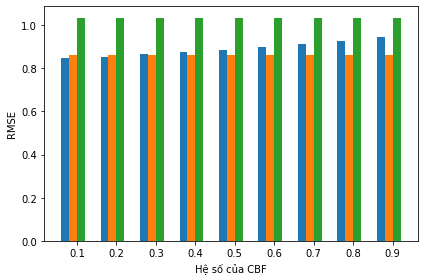

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ["0." + str(i) for i in range(1, 10)]
hybrid_means = rmse_hybrid
ncf_means = rmse_ncf
cbf_means = rmse_cbf

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.3, hybrid_means, width, label='Hybrid')
rects2 = ax.bar(x - 0.1, ncf_means, width, label='NCF')
rects3 = ax.bar(x + 0.1, cbf_means, width, label="CBF")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_xlabel('Hệ số của CBF')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

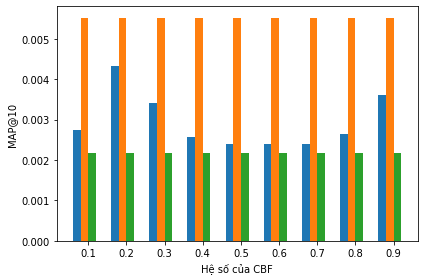

In [ ]:
labels = ["0." + str(i) for i in range(1, 10)]
hybrid_means = map10_hybrid
ncf_means = map10_ncf
cbf_means = map10_cbf

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.3, hybrid_means, width, label='Hybrid')
rects2 = ax.bar(x - 0.1, ncf_means, width, label='NCF')
rects3 = ax.bar(x + 0.1, cbf_means, width, label="CBF")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAP@10')
ax.set_xlabel('Hệ số của CBF')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.legend(bbox_to_anchor=(1.1, 1.05))

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

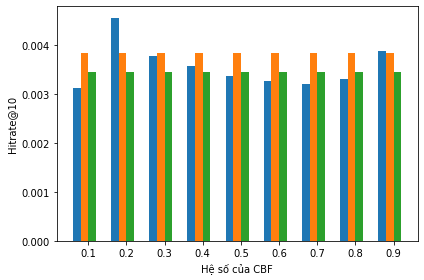

In [ ]:
labels = ["0." + str(i) for i in range(1, 10)]
hybrid_means = hitrate_hybrid
ncf_means = hitrate_ncf
cbf_means = hitrate_cbf

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.3, hybrid_means, width, label='Hybrid')
rects2 = ax.bar(x - 0.1, ncf_means, width, label='NCF')
rects3 = ax.bar(x + 0.1, cbf_means, width, label="CBF")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Hitrate@10')
ax.set_xlabel('Hệ số của CBF')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.legend(bbox_to_anchor=(1.1, 1.05))

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()